In [1]:
from generator import UniformCNFGenerator
from architectures import BasicRNN
from architectures import BaselineRollout
import utils
import train
import eval
import run

import torch
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from PyMiniSolvers import minisolvers

import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter

## Experiment 3

1. Create random sat formula
2. Check the number of sat clauses with the following solvers (mean over 10 times):
* Random assignment
* RNN model
* RNN model with greedy baseline

In [2]:
def experiment(experiment_name):
    num_experiments = 10 #num of times each experiment is run

    #CNF Formula
    n = 20  # Num variables
    k = 3  # Clause size
    r = 4  # Radious
    
    #Network
    embedding_size = 32
    hidden_size = 128
    num_layers = 1
    cell = 'GRU'
    dropout = 0

    input_size = n  # Num of variables
    output_size = 2  # Two assignments: 0 or 1
    num_rollouts = -1  # For baseline. Greedy: -1, #Sampled: 1, 2, 3, ...n

    # Training
    lr = 0.001
    accumulation_steps = [1, 2, 3, 4, 5]
    entropy_weight = 0.0
    num_episodes = 500
    clip_val = None  # None, 1, 2, 3, ...n
    clip_logits = None # None, 1, 2, 3, ...n

    history = {'random': [], 'as1': [], 'as2': [], 'as3': [], 'as4': [], 'as5': []}

    # Create a sat generator
    sat_gen = UniformCNFGenerator(min_n = n,
                                    max_n = n,
                                    min_k = k,
                                    max_k = k,
                                    min_r = r,
                                    max_r = r)


    for _ in tqdm(range(num_experiments)):
        # Create a random sat formula
        n, r, m, formula = sat_gen.generate_formula()

        ##################################################################
        # Random Model                                                   #
        ##################################################################
        num_sat = run.random_solver(n, formula)
        history['random'].append(num_sat)
        

        ##################################################################
        # RNN with greedy baseline                                       #
        ##################################################################
        policy_network = BasicRNN(cell, input_size, embedding_size, hidden_size,
                            output_size, num_layers, dropout)
        baseline = BaselineRollout(-1)
        accumulation_steps = 1

        _, _, history_num_sat  = run.learning_solver(n, formula, policy_network, baseline, lr,
                                accumulation_steps, num_episodes, entropy_weight, clip_logits, clip_val)
        history['as1'].append(history_num_sat)

        ##################################################################
        # RNN with greedy baseline                                       #
        ##################################################################
        policy_network = BasicRNN(cell, input_size, embedding_size, hidden_size,
                            output_size, num_layers, dropout)
        baseline = BaselineRollout(-1)
        accumulation_steps = 2

        _, _, history_num_sat  = run.learning_solver(n, formula, policy_network, baseline, lr,
                                accumulation_steps, num_episodes, entropy_weight, clip_logits, clip_val)
        history['as2'].append(history_num_sat)

        ##################################################################
        # RNN with greedy baseline                                       #
        ##################################################################
        policy_network = BasicRNN(cell, input_size, embedding_size, hidden_size,
                            output_size, num_layers, dropout)
        baseline = BaselineRollout(-1)
        accumulation_steps = 3

        _, _, history_num_sat  = run.learning_solver(n, formula, policy_network, baseline, lr,
                                accumulation_steps, num_episodes, entropy_weight, clip_logits, clip_val)
        history['as3'].append(history_num_sat)

        ##################################################################
        # RNN with greedy baseline                                       #
        ##################################################################
        policy_network = BasicRNN(cell, input_size, embedding_size, hidden_size,
                            output_size, num_layers, dropout)
        baseline = BaselineRollout(-1)
        accumulation_steps = 4

        _, _, history_num_sat  = run.learning_solver(n, formula, policy_network, baseline, lr,
                                accumulation_steps, num_episodes, entropy_weight, clip_logits, clip_val)
        history['as4'].append(history_num_sat)

        ##################################################################
        # RNN with greedy baseline                                       #
        ##################################################################
        policy_network = BasicRNN(cell, input_size, embedding_size, hidden_size,
                            output_size, num_layers, dropout)
        baseline = BaselineRollout(-1)
        accumulation_steps = 5

        _, _, history_num_sat  = run.learning_solver(n, formula, policy_network, baseline, lr,
                                accumulation_steps, num_episodes, entropy_weight, clip_logits, clip_val)
        history['as5'].append(history_num_sat)
    
    return history

In [3]:
experiment_name = "exp3"
history = experiment(experiment_name)

100%|██████████| 10/10 [08:48<00:00, 52.83s/it]


In [19]:
results = {}
results['random'] = [np.mean(history['random'])] * 500
results['as1'] = torch.stack([torch.stack(history['as1'][i]) for i in range(10)], dim=-1).mean(dim=1).numpy()
results['as2'] = np.repeat(torch.stack([torch.stack(history['as2'][i]) for i in range(10)], dim=-1).mean(dim=1).numpy(), 2)
#results['as3'] = torch.stack([torch.stack(history['as3'][i]) for i in range(10)], dim=-1).mean(dim=1).numpy()
results['as4'] = np.repeat(torch.stack([torch.stack(history['as4'][i]) for i in range(10)], dim=-1).mean(dim=1).numpy(), 4)
results['as5'] = np.repeat(torch.stack([torch.stack(history['as5'][i]) for i in range(10)], dim=-1).mean(dim=1).numpy(), 5)

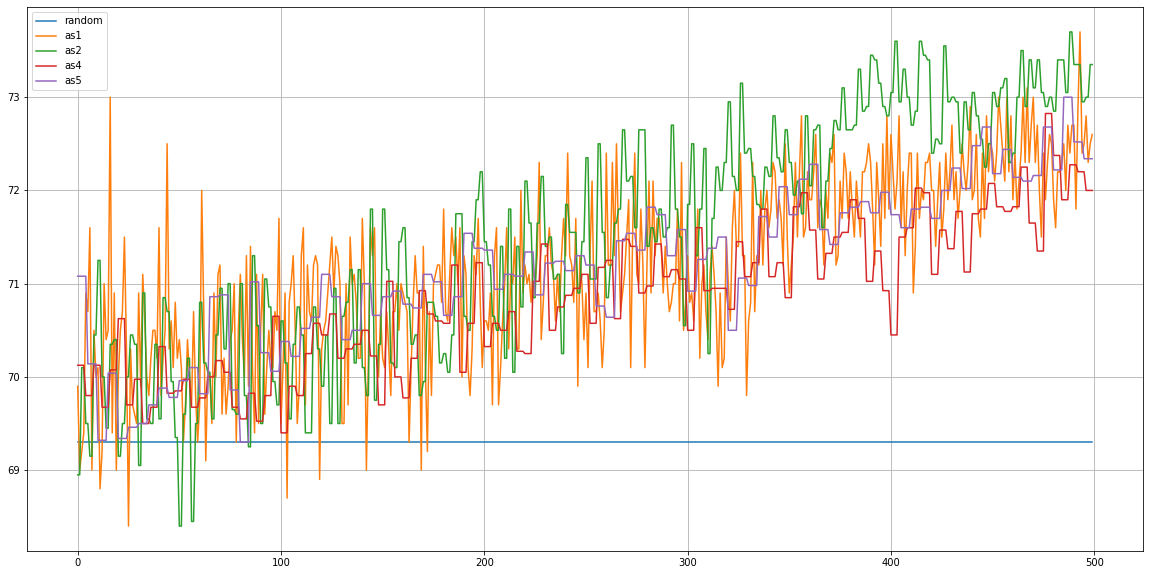

In [21]:
pd.DataFrame(results).plot(figsize=(20, 10))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # Establecer eje vertical en [0-1]
plt.show()

In [22]:
#Save dataframe as csv
csv_path = 'csv/exp3.csv'
df = pd.DataFrame(results)
df.to_csv(csv_path, index=False)